In [79]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import numpy as np
import matplotlib.pyplot as plt
import utils
import os
import random

In [80]:
def convertImg(image, size=(32,32)):
    converted = np.zeros(shape=(size[0], size[1], 1))
    for x in range(0, len(image)):
        for y in range(0, len(image[x])):
            converted[x][y][0] = image[x][y]

    converted = converted/255
    return converted

In [81]:
# trainImages / Images
ratio = 0.8
train_data = []
test_data = []

class_names = os.listdir('./trainData')
print(class_names)

for class_name in class_names:
    data = os.listdir('./trainData/{class_name}'.format(class_name=class_name))
    for i in range(0, len(data)):
        image = convertImg(utils.loadImage(path='./trainData/{class_name}'.format(class_name=class_name), name=data[i], resize=(32,32)))
        if(i/len(data) < ratio):
            train_data.append((image,class_names.index(class_name)))
        else:
            test_data.append((image,class_names.index(class_name)))

random.shuffle(train_data)
random.shuffle(test_data)

train_images = []
train_labels = []
test_images = []
test_labels = []

for data in train_data:
    train_images.append(data[0])
    train_labels.append([data[1]])

for data in test_data:
    test_images.append(data[0])
    test_labels.append([data[1]])

train_images = np.asarray(train_images)
train_labels = np.asarray(train_labels)
test_images = np.asarray(test_images)
test_labels = np.asarray(test_labels)

['capacitor', 'ground', 'resistor']


In [82]:
#(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
#
## Normalize pixel values to be between 0 and 1
#train_images, test_images = train_images / 255.0, test_images / 255.0
#
#print(test_images)

In [83]:
#print(test_images[0])

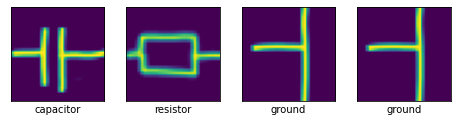

In [84]:
plt.figure(figsize=(10,10))
for i in range(4):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

In [85]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 30, 30, 32)        320       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_4 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)               

In [86]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))


Epoch 1/10
1/1 [==============================] - 1s 1s/step - loss: 2.3313 - accuracy: 0.0000e+00 - val_loss: 2.2110 - val_accuracy: 0.6667
Epoch 2/10
1/1 [==============================] - 0s 64ms/step - loss: 2.2110 - accuracy: 0.6667 - val_loss: 2.1028 - val_accuracy: 1.0000
Epoch 3/10
1/1 [==============================] - 0s 72ms/step - loss: 2.1028 - accuracy: 1.0000 - val_loss: 1.9696 - val_accuracy: 1.0000
Epoch 4/10
1/1 [==============================] - 0s 80ms/step - loss: 1.9696 - accuracy: 1.0000 - val_loss: 1.7979 - val_accuracy: 1.0000
Epoch 5/10
1/1 [==============================] - 0s 80ms/step - loss: 1.7979 - accuracy: 1.0000 - val_loss: 1.5834 - val_accuracy: 1.0000
Epoch 6/10
1/1 [==============================] - 0s 72ms/step - loss: 1.5834 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 1.0000
Epoch 7/10
1/1 [==============================] - 0s 80ms/step - loss: 1.3282 - accuracy: 1.0000 - val_loss: 1.0481 - val_accuracy: 1.0000
Epoch 8/10
1/1 [=========

1/1 - 0s - loss: 0.3255 - accuracy: 1.0000
1.0


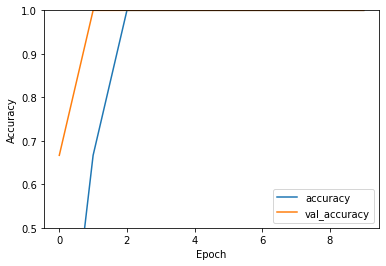

In [87]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print(test_acc)